The idea is to make several small notebooks to get a broad risk analysis of Canopy cover and crop

Risk analys:
- AAI, return period, Adaptation
- UNSEQUA 
- Cost-Benefit

Possible parameters:
- Country 
- crop and growing season
- empirical/calibrated impact function
- different hazards

Possible features:

Possible adaption measures:
- Full sun exposure
- Current canopy cover
- x % canopy cover 
- Cost to benefit estimation

Risk metrics

-  reduction in yield (%) / 

*IMPORTYNAT : You might have to simualte yearsets to account for years as events, but for EAI and return period this shoudl works since the frequency of an event is 1/# of events = 1/# of years*

What questions can we answer with this notebook

- The annual risk of VPD for yield
- The cost-benefit of increasing canopy cover


# Step 0 - Initial Parameters

In [1]:
from pathlib import Path
import os
# Get the data directory 
DATA_DIR = Path(os.path.join(os.getcwd(), '..', 'data')).resolve() # (one level above the current working directory)
# Check if the data directory exists
print(f"{DATA_DIR}")

OUTPUT_DIR = Path(os.path.join(os.getcwd(), '..', 'output')).resolve() # (one level above the current working directory)
# Check if the data directory exists
print(f"{OUTPUT_DIR}")

# Define bounding box for Mexico and Guatemala
bbox = {
    "lon_min": -120,
    "lon_max": -85,
    "lat_min": 13,
    "lat_max": 32
}

/Users/viggo/Documents/Programming/Consult/UNU/data
/Users/viggo/Documents/Programming/Consult/UNU/output


## Exposure – Coffe Yield

- Each raster value corresponds to **average yield (t/ha)** in a specific pixel during that year — not a time series.  
- Data from: [https://mapspam.info](https://mapspam.info)

✅ Summary for Arabica Yield

- **CSV column**: `coff_TA` (or `coff_TI`, `coff_TR`)
- **GeoTIFF**: `spam2020V1r0_global_Y_coff_TA.tif`
- **Unit**: Yield in metric **tonnes per hectare (t/ha)**
- **Year**: 2020
- **Resolution**: ~10 km × 10 km per pixel at the equator (**0.083333 degrees**, or 5 arc-minutes), global coverage  
  *(Each pixel aggregates data over an area of approximately 100 km².)*

📊 Variables

- `_Y_` → **Yield**  *tonnes per hectare (t/ha)*  
- `_A_` → **Physical area**  *hectares (ha) — total land area used for the crop, including multi-cropping*  
- `_H_` → **Harvested area**  *hectares (ha) — total area harvested, which may exceed physical area if multiple harvests occur per year*  
- `_P_` → **Production**  *tonnes (t) — total quantity of crop produced*

🧮 Yield Equation

- **Production (t)** = **Yield (t/ha)** × **Harvested Area (ha)**


In [2]:
from climada.entity import Exposures

# Load the exposure data
file = DATA_DIR / "spam2020V1r0_global_production 2/spam2020_v1r0_global_P_COFF_A.tif"
exp = Exposures.from_raster(file)
# Set the impact function id
exp.gdf['impf_VPD'] = 1
# Select only exposures inside the bounding box
exp_central_america = exp.gdf[
    (exp.gdf.geometry.x >= bbox["lon_min"]) &
    (exp.gdf.geometry.x <= bbox["lon_max"]) &
    (exp.gdf.geometry.y >= bbox["lat_min"]) &
    (exp.gdf.geometry.y <= bbox["lat_max"])
].copy()
# Remove all the rows with zero values
exp_central_america = exp_central_america[exp_central_america['value'] > 0]
# Make an Exposures object
exp_central_america = Exposures(data=exp_central_america)
exp_central_america.value_unit = 'tonnes'



               value  impf_VPD                     geometry
3426708     0.100000         1  POINT (-100.95833 23.87500)
3426709     0.100000         1  POINT (-100.87500 23.87500)
3426710     0.100000         1  POINT (-100.79167 23.87500)
3431028     0.600000         1  POINT (-100.95833 23.79167)
3431031     0.100000         1  POINT (-100.70833 23.79167)
...              ...       ...                          ...
3984157   793.299988         1   POINT (-86.87500 13.12500)
3984158   923.500000         1   POINT (-86.79167 13.12500)
3988474  2589.399902         1   POINT (-87.12500 13.04167)
3988475  4028.300049         1   POINT (-87.04167 13.04167)
3988476   399.100006         1   POINT (-86.95833 13.04167)

[3683 rows x 3 columns]


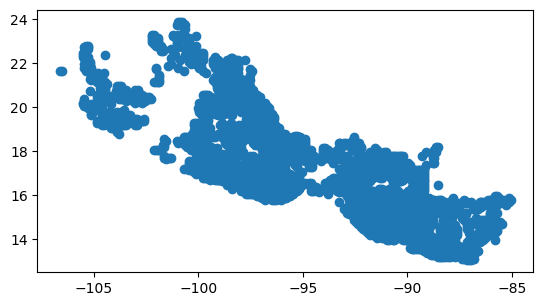

In [3]:
print(exp_central_america.gdf)
exp_central_america.plot()

### Add the Canopy Cover to the gdf

- https://www.globalforestwatch.org/
- https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html

For now just remove crop production grid points that give no canopy cover


IMPORTANT: Get better spatial resolution. Use Zelies data from canopy_cover to downscale where the actual coffe plantation is and where the acroforesty is. The maps resolution of 10 km x 10 km is to crude for canopy cover approximation. However start with this approach to see how the cost-benefit calcualtiona and unsequa could work.

In [4]:
import rasterio
from rasterio.merge import merge
from pathlib import Path
import glob

# Folder with your canopy tiles
canopy_dir = DATA_DIR / "Hansen_TreeCover"

# Find all the canopy files
tif_files = list(canopy_dir.glob("*.tif"))

# Open all files as datasets
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]

# Merge them into one mosaic (fills gaps automatically)
mosaic, out_trans = merge(src_files_to_mosaic)

# Copy metadata
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": 1
})

# Write the merged file
out_fp = DATA_DIR / "merged_treecover2000.tif"
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

# Close files
for src in src_files_to_mosaic:
    src.close()

print(f"Merged raster saved at: {out_fp}")


Merged raster saved at: /Users/viggo/Documents/Programming/Consult/UNU/data/merged_treecover2000.tif


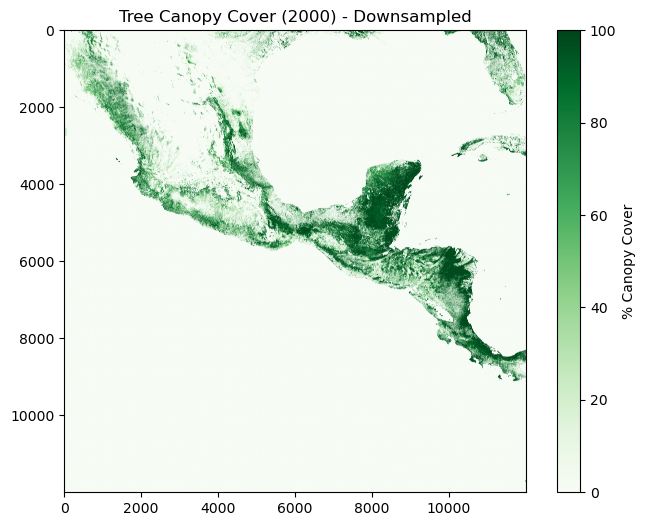

In [5]:
import rasterio
import matplotlib.pyplot as plt

# Path to your downloaded tree cover file
path_to_tif = DATA_DIR / "merged_treecover2000.tif"

# Open with rasterio
with rasterio.open(path_to_tif) as src:
    # Downsample by a factor of 10 (adjust this based on speed/quality tradeoff)
    tree_cover = src.read(
        1,
        out_shape=(
            int(src.height / 10),
            int(src.width / 10)
        )
    )

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(tree_cover, cmap='Greens')
plt.colorbar(label='% Canopy Cover')
plt.title('Tree Canopy Cover (2000) - Downsampled')
plt.show()


In [6]:
import geopandas as gpd
from rasterstats import zonal_stats
from climada.entity import Exposures

# Step 1: Buffer exposure points for zonal stats
exp_gdf = exp_central_america.gdf.to_crs(epsg=3857)  # Project to meters
exp_gdf["buffer_geom"] = exp_gdf.geometry.buffer(1000)  # 1 km buffer

# Step 2: Set buffer as geometry for zonal stats, then reproject to WGS84
buffered_gdf = exp_gdf.set_geometry("buffer_geom").to_crs("EPSG:4326")

# Step 3: Zonal mean tree cover from raster
canopy_tif = DATA_DIR / "merged_treecover2000.tif"
canopy_stats = zonal_stats(
    buffered_gdf,
    canopy_tif,
    stats=["mean"],
    nodata=0,
    all_touched=True
)

# Step 4: Attach stats to original GDF and clean
exp_gdf["canopy_cover_mean_1km"] = [s["mean"] for s in canopy_stats]
exp_gdf = exp_gdf[~exp_gdf["canopy_cover_mean_1km"].isna()]

# Step 5: Restore original point geometry and reproject to WGS84
exp_gdf = exp_gdf.set_geometry("geometry").to_crs("EPSG:4326")

# Step 6: Rebuild Exposures object
exp_central_america = Exposures(data=exp_gdf)
exp_central_america.value_unit = "tonnes"


Remove exposure points with no canopy cover (if any)

In [7]:
# Printt the value with NaN in canopy_cover_mean_1km
print(exp_central_america.gdf[exp_central_america.gdf["canopy_cover_mean_1km"].isna()])

# Remove the rows with NaN in canopy_cover_mean_1km
exp_central_america_gdf = exp_central_america.gdf[~exp_central_america.gdf["canopy_cover_mean_1km"].isna()]

# Check adn print the value with NaN in canopy_cover_mean_1km
print(exp_central_america_gdf[exp_central_america_gdf["canopy_cover_mean_1km"].isna()])

# Make an Exposures object
exp_central_america = Exposures(data=exp_central_america_gdf)
exp_central_america.value_unit = 'tonnes'

Empty GeoDataFrame
Columns: [value, impf_VPD, buffer_geom, canopy_cover_mean_1km, geometry]
Index: []
Empty GeoDataFrame
Columns: [value, impf_VPD, buffer_geom, canopy_cover_mean_1km, geometry]
Index: []


In [8]:
# Check the Exposures object
print(exp_central_america.gdf.head())

         value  impf_VPD                                        buffer_geom  \
3431031    0.1         1  POLYGON ((-11209800.385 2728042.257, -11209805...   
3435352    0.5         1  POLYGON ((-11200523.761 2717907.318, -11200528...   
3443991    0.6         1  POLYGON ((-11209800.385 2697656.826, -11209805...   
3443992    0.7         1  POLYGON ((-11200523.761 2697656.826, -11200528...   
3456945    0.6         1  POLYGON ((-11265460.131 2667329.103, -11265464...   

         canopy_cover_mean_1km                     geometry  
3431031              46.000000  POINT (-100.70833 23.79167)  
3435352               1.000000  POINT (-100.62500 23.70833)  
3443991              14.453704  POINT (-100.70833 23.54167)  
3443992               8.863636  POINT (-100.62500 23.54167)  
3456945              36.000000  POINT (-101.20833 23.29167)  


# Step 1 – Get the Hazard - VPD data

Load and Preprocess ERA5 daily data
- Is resolution (~25–28 km) ??

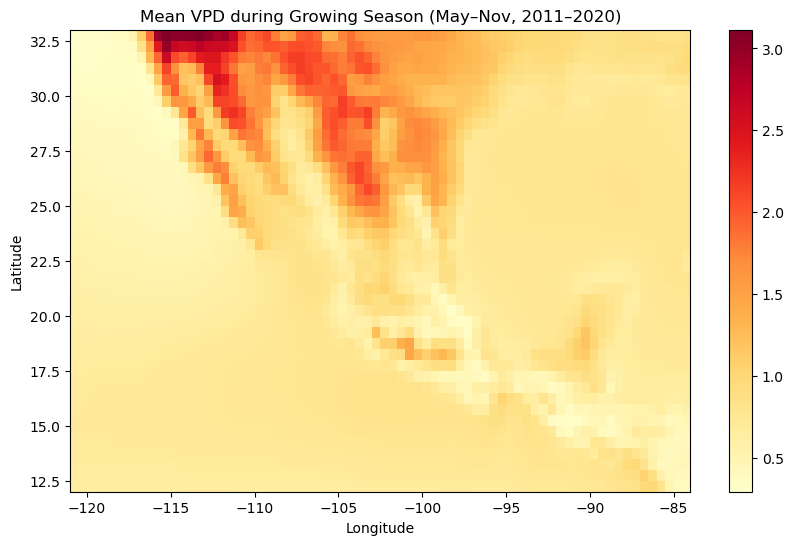

2025-05-20 16:17:20,233 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


<GeoAxes: title={'center': 'VPD max intensity at each point'}>

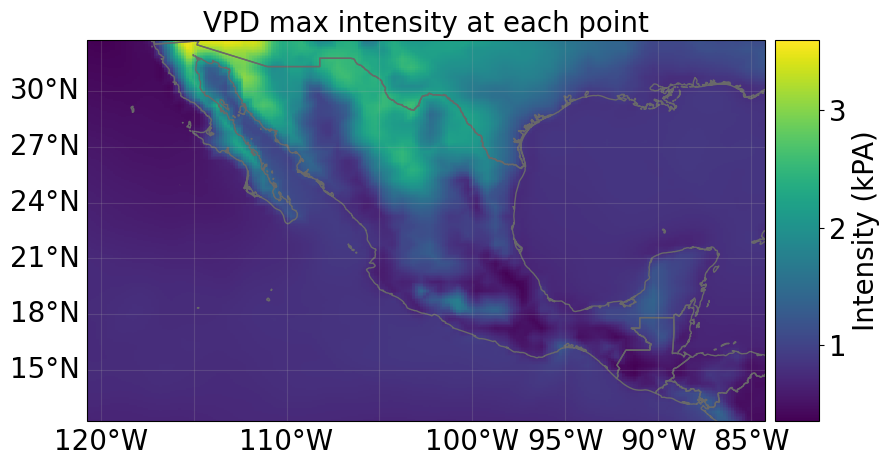

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from climada.hazard import Hazard

# Load datasets
humidity_path = DATA_DIR / "20crv3-era5_obsclim_hurs_global_daily_2011_2020.nc"
temperature_path = DATA_DIR / "20crv3-era5_obsclim_tas_global_daily_2011_2020.nc"

ds_hurs = xr.open_dataset(humidity_path)
ds_tas = xr.open_dataset(temperature_path)

# Assume variable names are 'hurs' and 'tas'
hurs = ds_hurs['hurs']
tas = ds_tas['tas']

# 🔥 First spatial subset
padding = 1 # Add a padding of 1 degree to match the bounding box of the exposure data
tas = tas.sel(lat=slice(bbox["lat_max"] + padding, bbox["lat_min"]- padding),
              lon=slice(bbox["lon_min"] - padding, bbox["lon_max"] + padding))
hurs = hurs.sel(lat=slice(bbox["lat_max"] + padding, bbox["lat_min"] - padding),
                 lon=slice(bbox["lon_min"] - padding, bbox["lon_max"] + padding)
)
# Convert temperature from Kelvin to Celsius
tas_celsius = tas - 273.15

# Select growing season months (May to November)
growing_season = tas_celsius['time.month'].isin([5, 6, 7, 8, 9, 10, 11])

tas_gs = tas_celsius.sel(time=growing_season)
hurs_gs = hurs.sel(time=growing_season)

# Calculate saturation vapour pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * tas_gs) / (tas_gs + 237.3))

# Calculate actual vapour pressure (ea) in kPa
ea = (hurs_gs / 100) * es

# Calculate VPD
vpd = es - ea

# Now groupby year and average VPD over growing season
vpd_yearly_mean = vpd.groupby('time.year').mean(dim='time')

# Final: average across all years (2011–2020)
vpd_growing_season_mean = vpd_yearly_mean.mean(dim='year')

# Plot
plt.figure(figsize=(10, 6))
vpd_growing_season_mean.plot(cmap="YlOrRd")
plt.title("Mean VPD during Growing Season (May–Nov, 2011–2020)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Convert to climada Hazard object

# Convert to xarray dataset for climada
vpd_dataset = vpd_yearly_mean.to_dataset(name='vpd')
# Add coordinates
vpd_dataset = vpd_dataset.rename({"year":"time","lat":"latitude","lon":"longitude"})
# Convert to Hazard object


haz_vpd = Hazard.from_xarray_raster(vpd_dataset, intensity='vpd', hazard_type='VPD', intensity_unit='kPA')
# Adjust the yearly frequency
haz_vpd.frequency = haz_vpd.frequency / len(haz_vpd.frequency )
# Plot the VPD hazard
haz_vpd.plot_intensity(0)


## Vulnerability 

vulnerability taken from this figure: https://www.nature.com/articles/s43016-022-00614-8/figures/1

- TODO: Look into or chnage vulnerability curve

<Axes: title={'center': 'VPD 1: Arabica VPD effect'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>

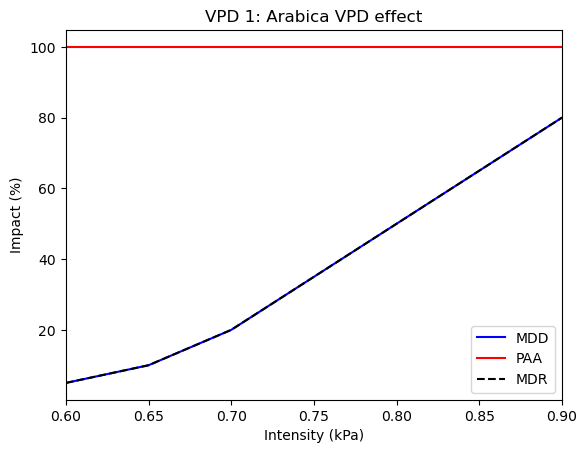

In [10]:
import numpy as np
import pandas as pd
from climada.entity import ImpactFunc

# Load your extracted VPD-effect table
vpd_data = pd.read_csv('vpd_effect_approximation.csv')
vpd_data = vpd_data[vpd_data.Effect_Central<0]
# Extract intensity (VPD) and effect (impact)
vpd_intensity = vpd_data['Mean_VPD_kPa'].values
effect = vpd_data['Effect_Central'].values

# CLIMADA needs MDD (mean damage degree), which must be between 0 and 1
# The "effect" is scaled roughly from -1 to 1 in the original paper figure
# We can map it to MDD: set 0 effect -> 0.5 MDD; -1 -> 1; 1 -> 0 (inverted risk)
mdd = -effect  # simple linear mapping

# Clip to valid range [0,1] just in case
mdd = np.clip(mdd, 0, 1)

# Assume full probability of asset affection (PAA)
paa = np.ones_like(mdd)

# Create the Impact Function
imp_fun_vpd = ImpactFunc(
    id=1,
    name="Arabica VPD effect",
    haz_type="VPD",  # you can define a custom hazard type
    intensity=vpd_intensity,
    mdd=mdd,
    paa=paa,
    intensity_unit="kPa"
)

# Check and plot
imp_fun_vpd.check()
imp_fun_vpd.plot()

In [11]:
# Store the impact function in impact function set
from climada.entity import ImpactFuncSet
# Create an empty ImpactFuncSet
impf_set = ImpactFuncSet()

# add the 2 impact functions into ImpactFuncSet
imp_fun_set = ImpactFuncSet([imp_fun_vpd])

## Impact calculations

In [31]:
new_exp.gdf

,value,impf_VPD,buffer_geom,canopy_cover_mean_1km,geometry,centr_VPD
3431031,0.100000,1,"POLYGON ((-11209800.385 2728042.257, -11209805...",46.000000,POINT (-100.70833 23.79167),0
3435352,0.500000,1,"POLYGON ((-11200523.761 2717907.318, -11200528...",1.000000,POINT (-100.62500 23.70833),1
3443991,0.600000,1,"POLYGON ((-11209800.385 2697656.826, -11209805...",14.453704,POINT (-100.70833 23.54167),2
3443992,0.700000,1,"POLYGON ((-11200523.761 2697656.826, -11200528...",8.863636,POINT (-100.62500 23.54167),3
3456945,0.600000,1,"POLYGON ((-11265460.131 2667329.103, -11265464...",36.000000,POINT (-101.20833 23.29167),4
...,...,...,...,...,...,...
3984157,793.299988,1,"POLYGON ((-9669880.763 1474016.837, -9669885.5...",37.775063,POINT (-86.87500 13.12500),3615
3984158,923.500000,1,"POLYGON ((-9660604.138 1474016.837, -9660608.9...",33.062620,POINT (-86.79167 13.12500),3616
3988474,2589.399902,1,"POLYGON ((-9697710.635 1464492.991, -9697715.4...",28.420635,POINT (-87.12500 13.04167),3617
3988475,4028.300049,1,"POLYGON ((-9688434.011 1464492.991, -9688438.8...",37.012672,POINT (-87.04167 13.04167),3618


2025-05-20 16:21:38,095 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
Expected annual impact (EAI): 169555.21 tonnes
Expected annual impact (%)(EAI): 21.22%


<Axes: title={'center': 'Exceedance frequency curve (% of exposed value)'}, xlabel='Return period (year)', ylabel='Impact (%)'>

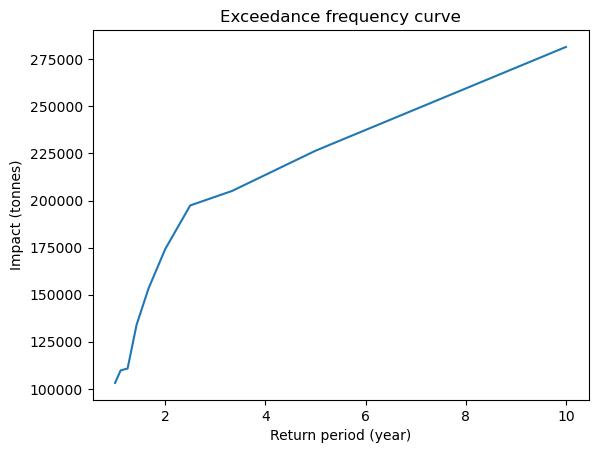

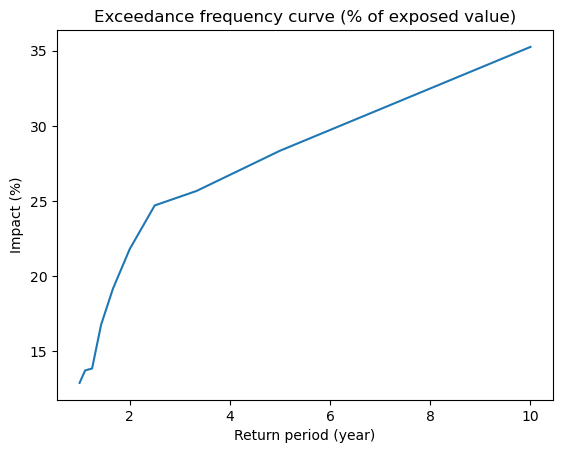

In [27]:
# Compute impact
from climada.engine import ImpactCalc, ImpactFreqCurve

# Assign the impact function to the exposures
exp_central_america.assign_centroids(haz_vpd, threshold=100000)
imp = ImpactCalc(exp_central_america, imp_fun_set, haz_vpd).impact(
    save_mat=False, assign_centroids = False
)  # Do not save the results geographically resolved (only aggregate values)


# Print the results
print(f"Expected annual impact (EAI): {imp.aai_agg:.2f} {exp_central_america.value_unit}")
print(f"Expected annual impact (%)(EAI): {imp.aai_agg/exp_central_america.gdf['value'].sum():.2%}")

# Plot the retunr period curve
imp.calc_freq_curve().plot()

# Plot the results as relative values
ifc = imp.calc_freq_curve()

# Step 2: Normalize impacts to % of total exposed value
total_value = exp_central_america.gdf.value.sum()  # total exposure in same unit as impact
impact_pct = 100 * ifc.impact / total_value     # convert to percentage

# Step 3: Create a new ImpactFreqCurve with percent unit
ifc_pct = ImpactFreqCurve(
    return_per=ifc.return_per,
    impact=impact_pct,
    unit="%",                     # update unit for clarity
    frequency_unit=ifc.frequency_unit,
    label="Exceedance frequency curve (% of exposed value)",
)

# Step 4: Plot
ifc_pct.plot()

## Adaptation Measures

Lets define three different adaptation Meaures – current tree shade and optimal tree shade each corresponding to a different hazard VPD set

Compute the hazard intensity given the shading 

In [14]:
from climada.hazard.centroids import Centroids
from climada.entity import Exposures
from scipy import sparse
import numpy as np
import pandas as pd
import xarray as xr

def compute_vpd_hazard(exp: Exposures, tas_gs: xr.DataArray, hurs_gs: xr.DataArray, canopy_scenario="current") -> Hazard:
    """Compute CLIMADA VPD Hazard from interpolated tas/hurs and exposure with optional canopy scenario."""
    
    # 1. Extract canopy cover
    if canopy_scenario == "current":
        canopy_cover = exp.gdf["canopy_cover_mean_1km"].values
    elif canopy_scenario is None or canopy_scenario == "none":
        canopy_cover = np.zeros(len(exp.gdf))
    elif isinstance(canopy_scenario, (int, float)):
        canopy_cover = np.full(len(exp.gdf), canopy_scenario)
    else:
        raise ValueError("Invalid canopy_scenario. Use 'current', None/'none', or float value (e.g., 50).")

    # 2. Interpolate temperature and humidity
    tas_pts = tas_gs.interp(
        lon=("site", exp.gdf.geometry.x.values),
        lat=("site", exp.gdf.geometry.y.values),
        method="nearest"
    )
    
    hurs_pts = hurs_gs.interp(
        lon=("site", exp.gdf.geometry.x.values),
        lat=("site", exp.gdf.geometry.y.values),
        method="nearest"
    )

    # 3. Apply cooling
    def delta_temp(canopy_pct):
        return -0.06 * canopy_pct  # Linear cooling model

    cooling = delta_temp(canopy_cover)
    tas_shaded = tas_pts + cooling[np.newaxis, :]  # broadcast across time

    # 4. Compute VPD
    es = 0.6108 * np.exp((17.27 * tas_shaded) / (tas_shaded + 237.3))
    ea = (hurs_pts / 100) * es
    vpd = es - ea  # shape: [time, site]

    # 5. Group by year
    vpd_df = vpd.groupby("time.year").mean("time").to_pandas()
    years = pd.to_numeric(vpd_df.index, errors='coerce').dropna().astype(int)

    # 6. Convert to Hazard
    intensity = sparse.csr_matrix(vpd_df.values)
    fraction = intensity.copy(); fraction.data.fill(1)
    lat = exp.gdf.geometry.y.values
    lon = exp.gdf.geometry.x.values

    # Check if the intensity matrix has NaN values
    if np.isnan(intensity.data).any():
        raise ValueError("Intensity matrix contains NaN values.")

    haz = Hazard(
        haz_type="VPD",
        intensity=intensity,
        fraction=fraction,
        centroids=Centroids(lat=lat, lon=lon),
        units="kPa",
        event_id=np.arange(len(years)),
        frequency=np.ones(len(years)) / len(years),
        date=np.array([pd.Timestamp(f"{y}-01-01").toordinal() for y in years]),
        event_name=[f"year_{y}" for y in years]
    )

    return haz


Store as a hazard 

Stored hazard unshaded in /Users/viggo/Documents/Programming/Consult/UNU/output/haz_vpd_unshaded.h5
Stored hazard shaded in /Users/viggo/Documents/Programming/Consult/UNU/output/haz_vpd_shaded.h5
Stored hazard current in /Users/viggo/Documents/Programming/Consult/UNU/output/haz_vpd_current.h5


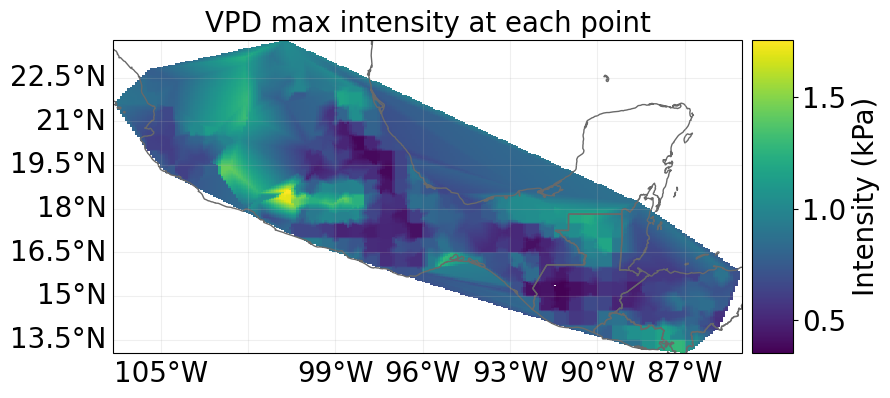

In [15]:
haz_dict = {}
shade_level = 50

# Haz unshaded
haz_dict["unshaded"] = compute_vpd_hazard(exp_central_america, tas_gs, hurs_gs, canopy_scenario=None)
haz_dict["shaded"] = compute_vpd_hazard(exp_central_america, tas_gs, hurs_gs, canopy_scenario=shade_level)
haz_dict["current"] = compute_vpd_hazard(exp_central_america, tas_gs, hurs_gs, canopy_scenario="current")

# View the hazard
haz_dict["unshaded"].plot_intensity(0)

# Store the hazard in the hazard as h5 format in the output directory
for key, haz in haz_dict.items():
    haz.write_hdf5(OUTPUT_DIR / f"haz_vpd_{key}.h5")
    print(f"Stored hazard {key} in {OUTPUT_DIR / f'haz_vpd_{key}.h5'}")

Define the measures

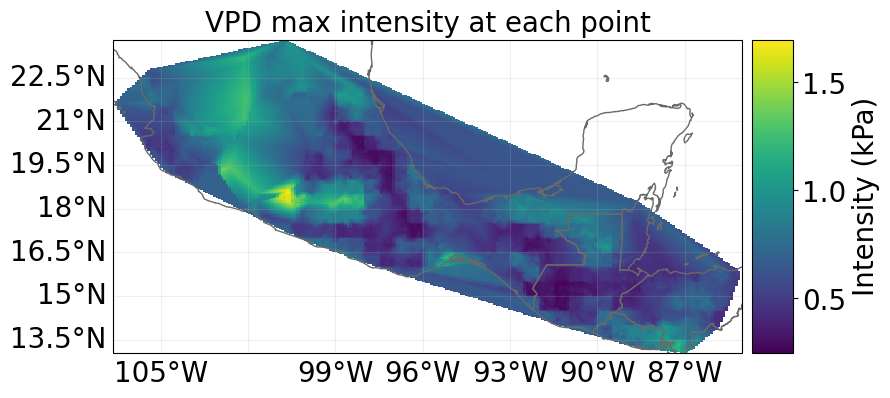

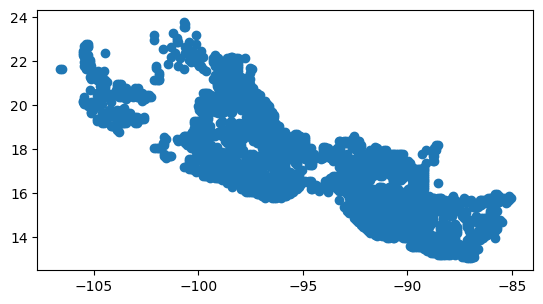

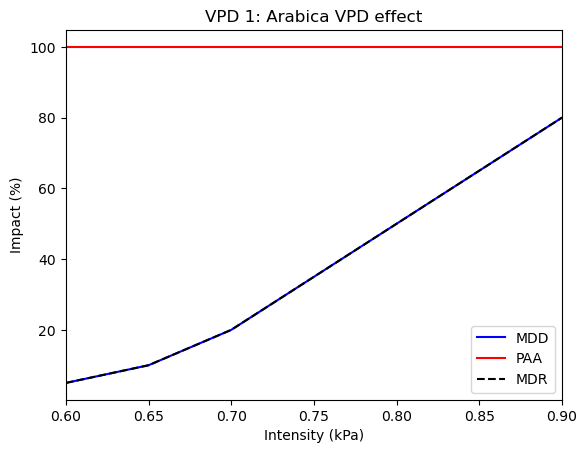

In [16]:
from climada.entity.measures import Measure, MeasureSet

# Define the measure
meas_shaded =  Measure(
    name=f"Shaded {shade_level}%",
    haz_type="VPD",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    hazard_set = OUTPUT_DIR / "haz_vpd_shaded.h5",
)

meas_current =  Measure(
    name="Current",
    haz_type="VPD",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    hazard_set = OUTPUT_DIR / "haz_vpd_current.h5",
)

meas_unshaded =  Measure(
    name="Unshaded",
    haz_type="VPD",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    hazard_set = OUTPUT_DIR / "haz_vpd_unshaded.h5",
)



# Store the measures in an measure set
# gather all measures
meas_set = MeasureSet()
meas_set.append(meas_shaded)
meas_set.append(meas_unshaded)
meas_set.append(meas_current)
meas_set.check()

# Apply the measure to the exposure
new_exp, new_impfs, new_haz = meas_current.apply(exp_central_america, imp_fun_set, haz_vpd)
# Check the new exposure and impact function and hazard
new_haz.plot_intensity(0)
new_haz.check()
new_exp.plot()
new_exp.check()
new_impfs.plot()
new_impfs.check()


Calculate the impact and cost-benefit for different measures 

In [30]:
# Calculate the impact for each measure

# select one measure
#meas_sel = meas_set.get_measure(name="Shaded")
# print the selected measure
#print(meas_sel[0].name, meas_sel[0].cost)

# Create an empty dictionary to store the impact results
imp_meas = {}

# Loop through each measure in the measure set dictionary
for measure_name, meas_sel in meas_set.get_measure()['VPD'].items():
    # Apply the measure to the exposure
    new_exp, new_impfs, new_haz = meas_sel.apply(exp_central_america, imp_fun_set, haz_vpd)
    # Calculate the impact
    imp = ImpactCalc(new_exp, new_impfs, new_haz).impact(
        save_mat=False
    )  # Do not save the results geographically resolved (only aggregate values)
    # Store the impact in the dictionary
    imp_meas[measure_name] = imp

2025-05-20 16:22:49,340 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-05-20 16:22:49,364 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-05-20 16:22:49,386 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


Expected annual impact (EAI) for Shaded 50%: 95595.57 tonnes
Expected annual impact (%) for Shaded 50%: 11.97%
Expected annual impact (EAI) for Unshaded: 169555.19 tonnes
Expected annual impact (%) for Unshaded: 21.22%
Expected annual impact (EAI) for Current: 98920.03 tonnes
Expected annual impact (%) for Current: 12.38%


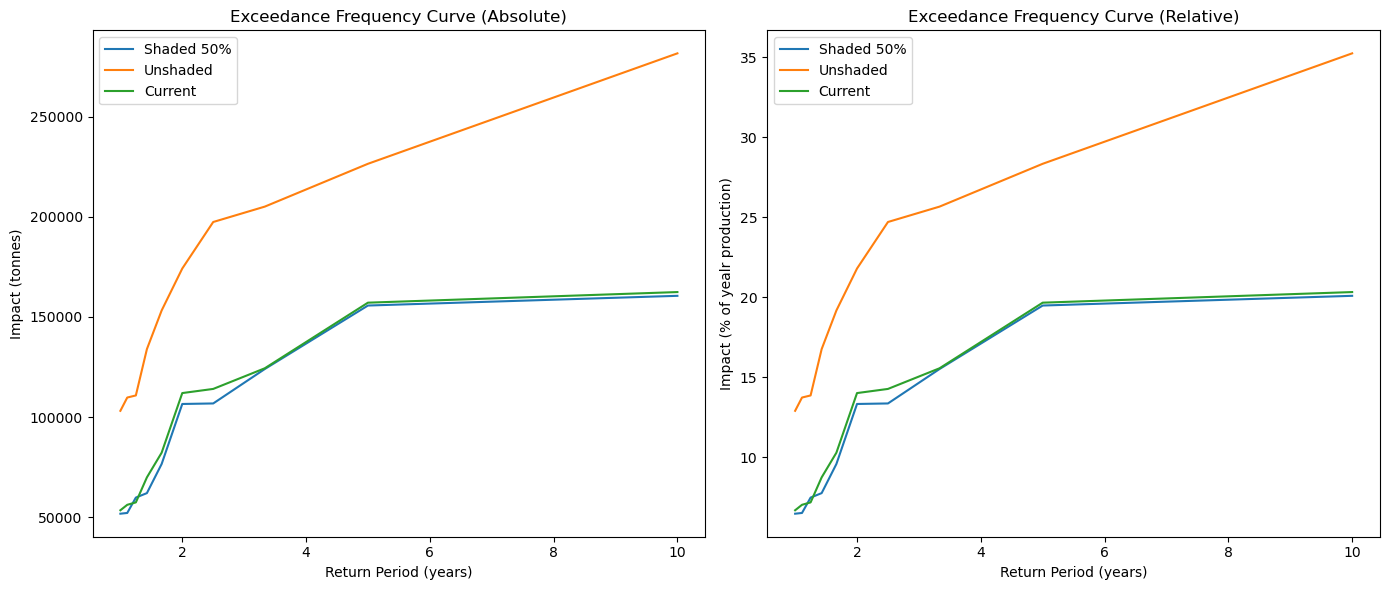

In [18]:
from climada.engine import ImpactCalc, ImpactFreqCurve
import matplotlib.pyplot as plt

# Create figure with two subplots: absolute and relative
fig, (ax_abs, ax_pct) = plt.subplots(1, 2, figsize=(14, 6))

for measure_name, imp in imp_meas.items():
    # 1. Print expected annual impact
    print(f"Expected annual impact (EAI) for {measure_name}: {imp.aai_agg:.2f} {exp_central_america.value_unit}")
    print(f"Expected annual impact (%) for {measure_name}: {imp.aai_agg / exp_central_america.gdf['value'].sum():.2%}")
    
    # 2. Compute frequency curve
    ifc = imp.calc_freq_curve()
    
    # 3. Plot absolute curve
    ifc.plot(label=measure_name, axis=ax_abs)
    
    # 4. Normalize for relative impact (%)
    total_value = exp_central_america.gdf["value"].sum()
    impact_pct = 100 * ifc.impact / total_value
    
    ifc_pct = ImpactFreqCurve(
        return_per=ifc.return_per,
        impact=impact_pct,
        unit="%",
        frequency_unit=ifc.frequency_unit,
        label=f"{measure_name} (% of exposed)",
    )
    
    # 5. Plot relative curve
    ifc_pct.plot(label=measure_name, axis=ax_pct)

# Customize plots
ax_abs.set_title("Exceedance Frequency Curve (Absolute)")
ax_abs.set_xlabel("Return Period (years)")
ax_abs.set_ylabel(f"Impact ({exp_central_america.value_unit})")
ax_abs.legend()

ax_pct.set_title("Exceedance Frequency Curve (Relative)")
ax_pct.set_xlabel("Return Period (years)")
ax_pct.set_ylabel("Impact (% of yealr production)")
ax_pct.legend()

plt.tight_layout()
plt.show()


### Make a cost-benefit calculation

Make the present and future exposure

In [19]:
import copy

# MAke present and future scenarios
present_year = 2025
exp_present = copy.deepcopy(exp_central_america)
exp_present.ref_year = present_year
# Set the future year
future_year = 2030
exp_future = copy.deepcopy(exp_central_america)
exp_future.ref_year = future_year
# Set the growth rate
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

Define the discount curves

In [20]:
from climada.entity import DiscRates

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_zero = np.zeros(n_years)
discount_zero = DiscRates(year_range, annual_discount_zero)


Define the entity

In [21]:
from climada.entity import Entity

entity_present = Entity(
    exposures=exp_present,
    disc_rates=discount_zero,
    impact_func_set= imp_fun_set,
    measure_set=meas_set
)
entity_future = Entity(
    exposures=exp_future,
    disc_rates=discount_zero,
    impact_func_set=imp_fun_set,
    measure_set=meas_set,
)



Calculate the cost-benefit

2025-05-20 16:17:34,473 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-05-20 16:17:34,497 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-05-20 16:17:34,521 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-05-20 16:17:34,541 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.

Measure       Cost (tonnes k)    Benefit (tonnes k)    Benefit/Cost
----------  -----------------  --------------------  --

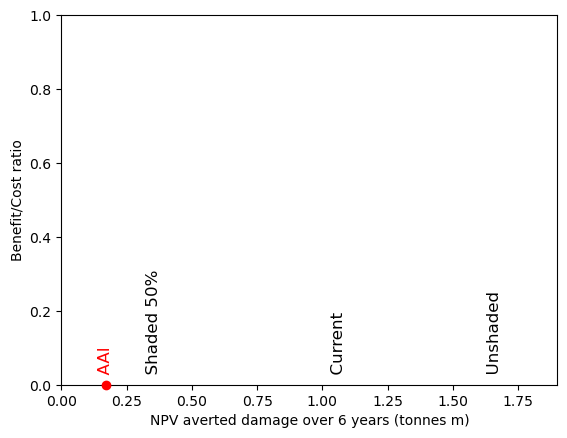

In [22]:
from climada.engine import CostBenefit
from climada.engine.cost_benefit import risk_aai_agg

costben_measures_no_climate_change = CostBenefit()
costben_measures_no_climate_change.calc(
    haz_vpd,
    entity_present,
    haz_future=None,
    ent_future=None,
    future_year=future_year,
    risk_func=risk_aai_agg,
    imp_time_depen=None,
    save_imp=True,
)

# Plotting the results
ax = costben_measures_no_climate_change.plot_cost_benefit()